#AIM:

Generate random sequences, fold them with RNAfold, learn the mapping between seq features and struct features

Measure how good the mapping is by trying to learn the two version apart

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=0)

In [2]:
from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import sequence_to_eden
from eden.util import mp_pre_process
from eden.util import vectorize
from eden import graph

In [3]:
from eden.util.display import draw_graph
import itertools
def plot(graphs, num=3, opts=None):    
    graphs = itertools.islice(graphs,num)
    for i,graph in enumerate(graphs): 
        draw_graph(graph, **opts)

In [4]:
import random
def generate_rna_seq(length=30, gc_content=0.5):
    n_g=int(gc_content * length / 2)
    n_c=int(gc_content * length / 2)
    n_a=int((1 - gc_content) * length / 2)
    n_u=int((1 - gc_content) * length / 2)
    seq = list('G'*n_g + 'C'*n_c + 'A'*n_a + 'U'*n_u)
    random.shuffle(seq)
    seq = ''.join(seq)
    return seq

def generate_rna_seqs(num=100, length=30, gc_content=0.5):
    seqs = []
    for i in range(num):
        seqs.append(('ID_%d'%i, generate_rna_seq(length=length, gc_content=gc_content)))
    return seqs

In [5]:
def plot_examples(seqs, pre_processor=None):
    graphs = mp_pre_process(seqs,
                            pre_processor=pre_processor,
                            pre_processor_args={},
                            n_jobs=-1)    
    opts={'size':8,
          'node_border':False,
          'node_size':400,
          'font_size':9,
          'vertex_alpha':0.6,
          'title_key':'id',
          'vertex_color':'_labels_',
          'colormap':'Set1',
          'prog':'neato'}
    plot(graphs, num=None, opts=opts)

In [6]:
#RNAplfold
def pre_processor(seqs):
    from eden.converter.rna.rnaplfold import rnaplfold_to_eden
    graphs = rnaplfold_to_eden(seqs,
                               window_size = 30,
                               max_bp_span = 20,
                               avg_bp_prob_cutoff = 0.5,
                               max_num_edges = 1)
    from eden.modifier.graph import structure 
    graphs = structure.make_edge_type_into_nesting(graphs, edge_type_key='basepair')
    return graphs

In [7]:
#RNAfold
def pre_processor(seqs):
    from eden.converter.rna.rnafold import rnafold_to_eden
    graphs = rnafold_to_eden(seqs)
    from eden.modifier.graph import structure 
    graphs = structure.make_edge_type_into_nesting(graphs, edge_type_key='basepair')
    return graphs

In [8]:
from eden.util import mp_pre_process
from eden.util import vectorize
def transformer(seqs, vectorizer=None, pre_processor=None):
    graphs = mp_pre_process(seqs,
                            pre_processor=pre_processor,
                            pre_processor_args={},
                            n_jobs=-1)
    data_matrix = vectorize(graphs, vectorizer=vectorizer, n_jobs=-1)
    return data_matrix

#Experimental setup

In [9]:
num=200
length=17
gc_content=0.6
nbits=10

In [10]:
seqs = generate_rna_seqs(num=num, length=length, gc_content=gc_content)

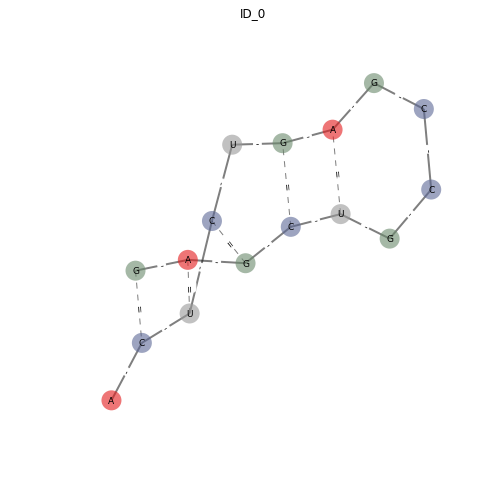

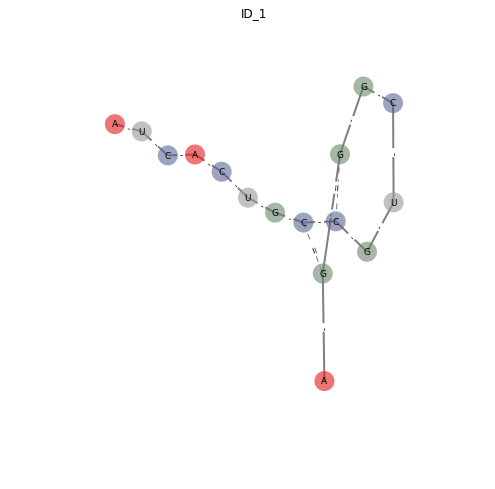

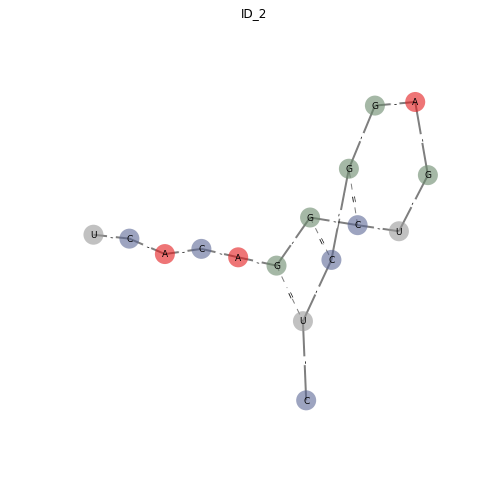

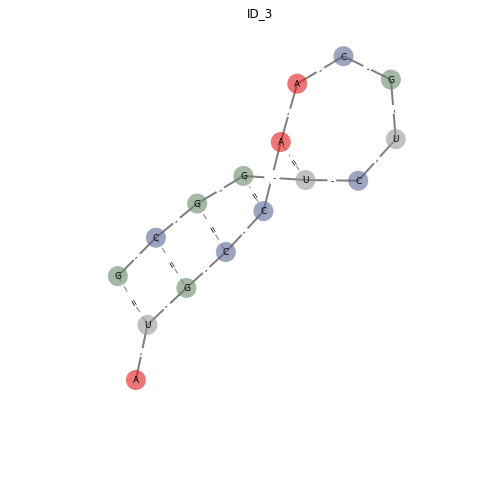

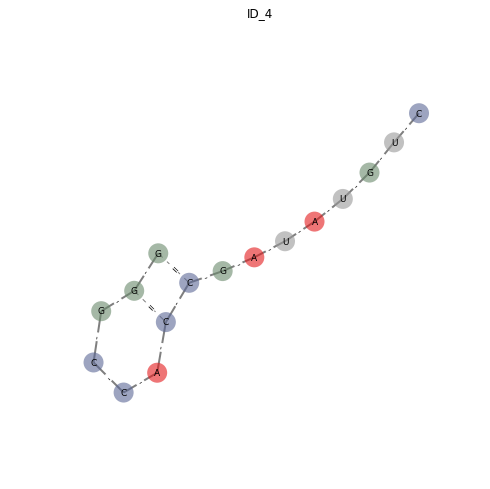

In [11]:
plot_examples(seqs[:5],pre_processor)

In [12]:
%%time
from eden.converter.fasta import sequence_to_eden
from eden import graph
X_seq = transformer(seqs,
                    vectorizer=graph.Vectorizer(r=3,d=17,min_r=2,
                                                normalization=False,
                                                inner_normalization=False,
                                                nbits=nbits),
                    pre_processor=sequence_to_eden)
from eden.util import describe
print describe(X_seq)
print X_seq

Instances: 200 ; Features: 1025 with an avg of 234 features per instance
  (0, 2)	2.0
  (0, 9)	2.0
  (0, 11)	2.0
  (0, 12)	2.0
  (0, 13)	2.0
  (0, 14)	2.0
  (0, 18)	2.0
  (0, 21)	2.0
  (0, 22)	2.0
  (0, 30)	2.0
  (0, 38)	2.0
  (0, 44)	2.0
  (0, 52)	1.0
  (0, 54)	2.0
  (0, 58)	2.0
  (0, 61)	2.0
  (0, 62)	2.0
  (0, 64)	2.0
  (0, 68)	2.0
  (0, 74)	2.0
  (0, 77)	2.0
  (0, 81)	2.0
  (0, 86)	2.0
  (0, 90)	2.0
  (0, 93)	2.0
  :	:
  (199, 937)	2.0
  (199, 942)	1.0
  (199, 948)	2.0
  (199, 951)	2.0
  (199, 954)	1.0
  (199, 955)	2.0
  (199, 956)	2.0
  (199, 961)	2.0
  (199, 962)	2.0
  (199, 964)	2.0
  (199, 969)	2.0
  (199, 974)	2.0
  (199, 975)	2.0
  (199, 981)	2.0
  (199, 982)	2.0
  (199, 984)	1.0
  (199, 988)	2.0
  (199, 999)	2.0
  (199, 1001)	2.0
  (199, 1002)	1.0
  (199, 1003)	2.0
  (199, 1006)	2.0
  (199, 1007)	2.0
  (199, 1012)	1.0
  (199, 1018)	2.0
CPU times: user 321 ms, sys: 112 ms, total: 433 ms
Wall time: 812 ms


In [13]:
%%time
from eden.converter.fasta import sequence_to_eden
from eden import graph
X_struct = transformer(seqs,
                       vectorizer=graph.Vectorizer(r=3,d=0,min_r=2,
                                                   normalization=False,
                                                   inner_normalization=False,
                                                   nbits=nbits),
                       pre_processor=pre_processor)
from eden.util import describe
print describe(X_struct)
print X_struct

Instances: 200 ; Features: 1025 with an avg of 31 features per instance
  (0, 52)	1.0
  (0, 103)	1.0
  (0, 174)	1.0
  (0, 194)	1.0
  (0, 208)	1.0
  (0, 213)	1.0
  (0, 238)	1.0
  (0, 244)	1.0
  (0, 271)	1.0
  (0, 304)	1.0
  (0, 342)	1.0
  (0, 352)	2.0
  (0, 400)	3.0
  (0, 464)	1.0
  (0, 465)	1.0
  (0, 472)	1.0
  (0, 500)	1.0
  (0, 560)	1.0
  (0, 618)	1.0
  (0, 632)	2.0
  (0, 647)	1.0
  (0, 676)	1.0
  (0, 720)	1.0
  (0, 726)	1.0
  (0, 750)	1.0
  :	:
  (199, 298)	1.0
  (199, 342)	1.0
  (199, 390)	1.0
  (199, 400)	2.0
  (199, 462)	1.0
  (199, 464)	1.0
  (199, 472)	1.0
  (199, 484)	1.0
  (199, 554)	1.0
  (199, 560)	1.0
  (199, 618)	1.0
  (199, 728)	1.0
  (199, 786)	1.0
  (199, 790)	1.0
  (199, 800)	1.0
  (199, 806)	1.0
  (199, 810)	1.0
  (199, 816)	1.0
  (199, 846)	1.0
  (199, 864)	1.0
  (199, 942)	1.0
  (199, 954)	1.0
  (199, 984)	1.0
  (199, 1002)	1.0
  (199, 1012)	1.0
CPU times: user 366 ms, sys: 92 ms, total: 458 ms
Wall time: 1.06 s


In [14]:
from sklearn.preprocessing import StandardScaler
seq_scale = StandardScaler(with_mean=True)
X_seq_std = seq_scale.fit_transform(X_seq.todense())
print X_seq_std

[[ 0.         -0.5         1.85592145 ...,  2.0317985  -0.54653573
   1.93956303]
 [ 0.         -0.5        -0.53881591 ..., -0.49217479 -0.54653573
   1.93956303]
 [ 0.         -0.5        -0.53881591 ..., -0.49217479 -0.54653573
  -0.51558005]
 ..., 
 [ 0.         -0.5        -0.53881591 ..., -0.49217479 -0.54653573
  -0.51558005]
 [ 0.          2.         -0.53881591 ...,  2.0317985  -0.54653573
  -0.51558005]
 [ 0.          2.         -0.53881591 ..., -0.49217479 -0.54653573
  -0.51558005]]


In [15]:
from sklearn.preprocessing import StandardScaler
struct_scale = StandardScaler(with_mean=True)
X_struct_std = seq_scale.fit_transform(X_struct.todense())
print X_struct_std

[[ 0.         -0.07088812 -0.07088812 ...,  0.         -0.10050378  0.        ]
 [ 0.         -0.07088812 -0.07088812 ...,  0.         -0.10050378  0.        ]
 [ 0.         -0.07088812 -0.07088812 ...,  0.         -0.10050378  0.        ]
 ..., 
 [ 0.         -0.07088812 -0.07088812 ...,  0.         -0.10050378  0.        ]
 [ 0.         -0.07088812 -0.07088812 ...,  0.         -0.10050378  0.        ]
 [ 0.         -0.07088812 -0.07088812 ...,  0.         -0.10050378  0.        ]]


In [16]:
X_seq_std = X_seq.todense()
X_struct_std = X_struct.todense()

In [17]:
n_features_in = X_seq.shape[1]
n_features_out = X_struct.shape[1]
n_features_hidden = max(n_features_in, n_features_out) * 3
print 'n_neurons: #in [%d] -- #hidden [%d] -- #out [%d]' % (n_features_in, n_features_hidden, n_features_out)

n_neurons: #in [1025] -- #hidden [3075] -- #out [1025]


In [18]:
from sknn.mlp import Regressor, Layer

net = Regressor(layers=[
        Layer("Rectifier", units=n_features_hidden),
        Layer("Rectifier", units=n_features_hidden),
        Layer("Rectifier", units=n_features_hidden),
        Layer("Softmax", units=n_features_out)],
                learning_rate=0.001,
                regularize='L1',
                valid_size=0.1)

In [19]:
%%time
net.fit(X_seq_std, X_struct_std)

CPU times: user 2h 34min 29s, sys: 22min 33s, total: 2h 57min 3s
Wall time: 3h 52s


Regressor(batch_size=1, debug=False, dropout_rate=None, f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: name=u'hidden0', units=3075>,
     hidden1=<sknn.nn.Layer `Rectifier`: name=u'hidden1', units=3075>,
     hidden2=<sknn.nn.Layer `Rectifier`: name=u'hidden2', units=3075>,
     layers=[<sknn.nn.Layer `Rectifier`: name=u'hidden0', units=3075>, <sknn.nn.Layer `Rectifier`: name=u'hidden1', units=3075>, <sknn.nn.Layer `Rectifier`: name=u'hidden2', units=3075>, <sknn.nn.Layer `Softmax`: name=u'output', units=1025>],
     learning_momentum=0.9, learning_rate=0.001, learning_rule=u'sgd',
     loss_type=u'mse', mutator=None, n_iter=None, n_stable=50,
     output=<sknn.nn.Layer `Softmax`: name=u'output', units=1025>,
     random_state=None, regularize='L1',
     valid_set=(matrix([[ 0.,  0., ...,  0.,  2.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  2.,  0.]]), matrix([[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ..., 

In [20]:
%%time
# Transform seq features to struct features
X_struct_std_pred = net.predict(X_seq_std)

CPU times: user 946 ms, sys: 8.86 ms, total: 954 ms
Wall time: 140 ms


In [21]:
import pylab as plt
import numpy as np

original_data = np.array(np.ravel(X_struct_std))
predicted_data = np.array(np.ravel(X_struct_std_pred))

combined_data = np.vstack([original_data,predicted_data])
gamma = np.corrcoef(combined_data)
print 'corr_coeff: %.3f' % gamma[0,1]
print 'n datapoints: %d' % predicted_data.shape[0]

noise = 0.065 * np.random.randn(*original_data.shape)
noisy_original_data = noise + original_data

corr_coeff: 0.930
n datapoints: 205000


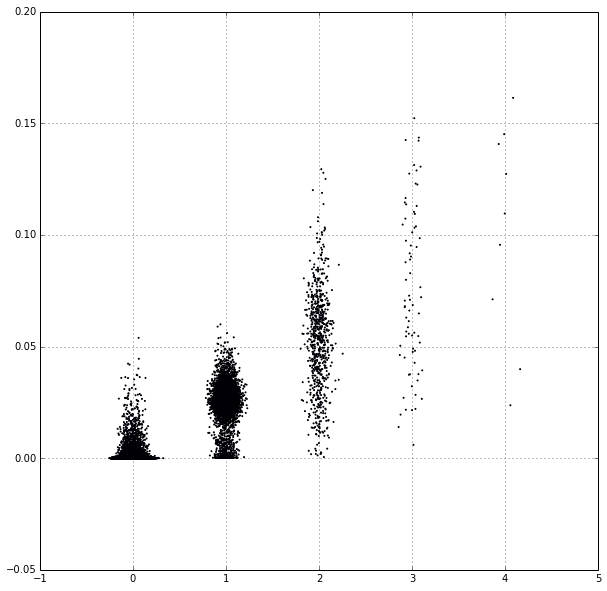

CPU times: user 8.32 s, sys: 33.1 ms, total: 8.36 s
Wall time: 8.36 s


In [22]:
%%time
plt.figure(figsize=(10,10)) 
plt.scatter(noisy_original_data,predicted_data, s=1)
plt.grid()
plt.show()

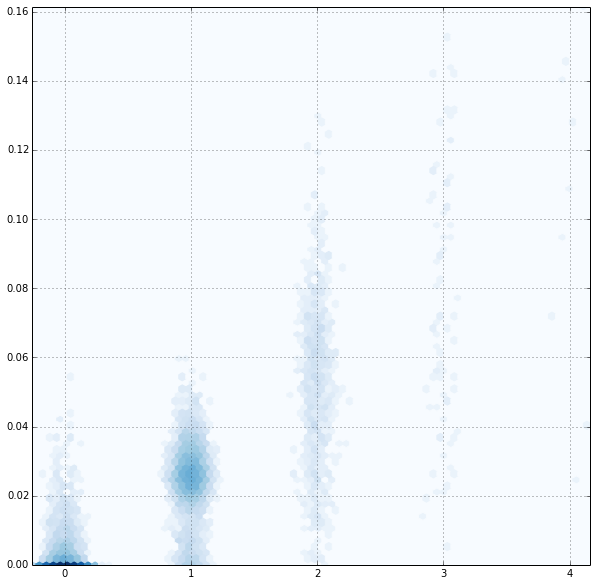

CPU times: user 1.64 s, sys: 46.5 ms, total: 1.68 s
Wall time: 1.67 s


In [23]:
%%time
plt.figure(figsize=(10,10)) 
plt.hexbin(noisy_original_data,predicted_data, 
           bins='log', gridsize=80, cmap='Blues')
plt.grid()
plt.show()

coef:10.00 corr_coeff: 0.478
coef:14.74 corr_coeff: 0.572
coef:19.47 corr_coeff: 0.764
coef:24.21 corr_coeff: 0.898
coef:28.95 corr_coeff: 0.924
coef:33.68 corr_coeff: 0.930
coef:38.42 corr_coeff: 0.924
coef:43.16 corr_coeff: 0.913
coef:47.89 corr_coeff: 0.905
coef:52.63 corr_coeff: 0.901
coef:57.37 corr_coeff: 0.906
coef:62.11 corr_coeff: 0.915
coef:66.84 corr_coeff: 0.923
coef:71.58 corr_coeff: 0.926
coef:76.32 corr_coeff: 0.926
coef:81.05 corr_coeff: 0.925
coef:85.79 corr_coeff: 0.923
coef:90.53 corr_coeff: 0.922
coef:95.26 corr_coeff: 0.923
coef:100.00 corr_coeff: 0.924


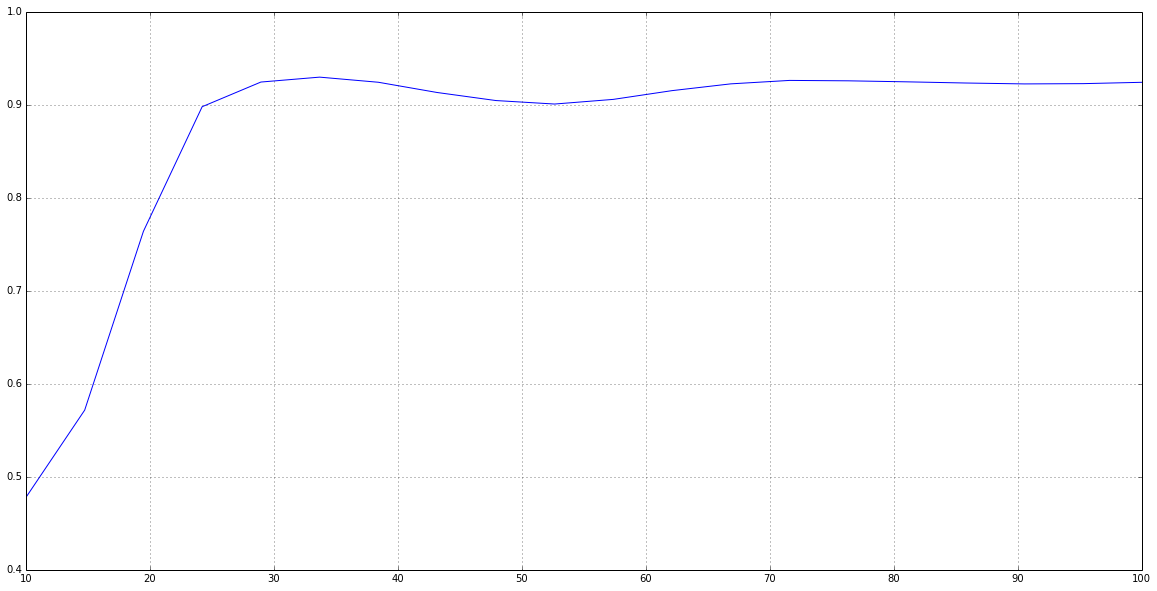

In [24]:
coefs=[]
ccs=[]
for coef in np.linspace(10, 100, num=20):
    noise = 0.065 * np.random.randn(*predicted_data.shape)
    noisy_predicted_data = np.round(predicted_data*coef) + noise
    combined_data = np.vstack([original_data,np.round(predicted_data*coef)])
    gamma = np.corrcoef(combined_data)
    cc = gamma[0,1]
    coefs.append(coef)
    ccs.append(cc)
    print 'coef:%.2f corr_coeff: %.3f' % (coef, cc)

plt.figure(figsize=(20,10)) 
plt.plot(coefs,ccs)
plt.grid()
plt.show()

coef:25.00 corr_coeff: 0.9063
coef:25.15 corr_coeff: 0.9074
coef:25.30 corr_coeff: 0.9086
coef:25.45 corr_coeff: 0.9098
coef:25.61 corr_coeff: 0.9109
coef:25.76 corr_coeff: 0.9118
coef:25.91 corr_coeff: 0.9125
coef:26.06 corr_coeff: 0.9134
coef:26.21 corr_coeff: 0.9141
coef:26.36 corr_coeff: 0.9152
coef:26.52 corr_coeff: 0.9161
coef:26.67 corr_coeff: 0.9166
coef:26.82 corr_coeff: 0.9171
coef:26.97 corr_coeff: 0.9181
coef:27.12 corr_coeff: 0.9190
coef:27.27 corr_coeff: 0.9198
coef:27.42 corr_coeff: 0.9206
coef:27.58 corr_coeff: 0.9210
coef:27.73 corr_coeff: 0.9217
coef:27.88 corr_coeff: 0.9220
coef:28.03 corr_coeff: 0.9220
coef:28.18 corr_coeff: 0.9227
coef:28.33 corr_coeff: 0.9234
coef:28.48 corr_coeff: 0.9237
coef:28.64 corr_coeff: 0.9238
coef:28.79 corr_coeff: 0.9241
coef:28.94 corr_coeff: 0.9244
coef:29.09 corr_coeff: 0.9247
coef:29.24 corr_coeff: 0.9248
coef:29.39 corr_coeff: 0.9249
coef:29.55 corr_coeff: 0.9254
coef:29.70 corr_coeff: 0.9258
coef:29.85 corr_coeff: 0.9264
coef:30.00

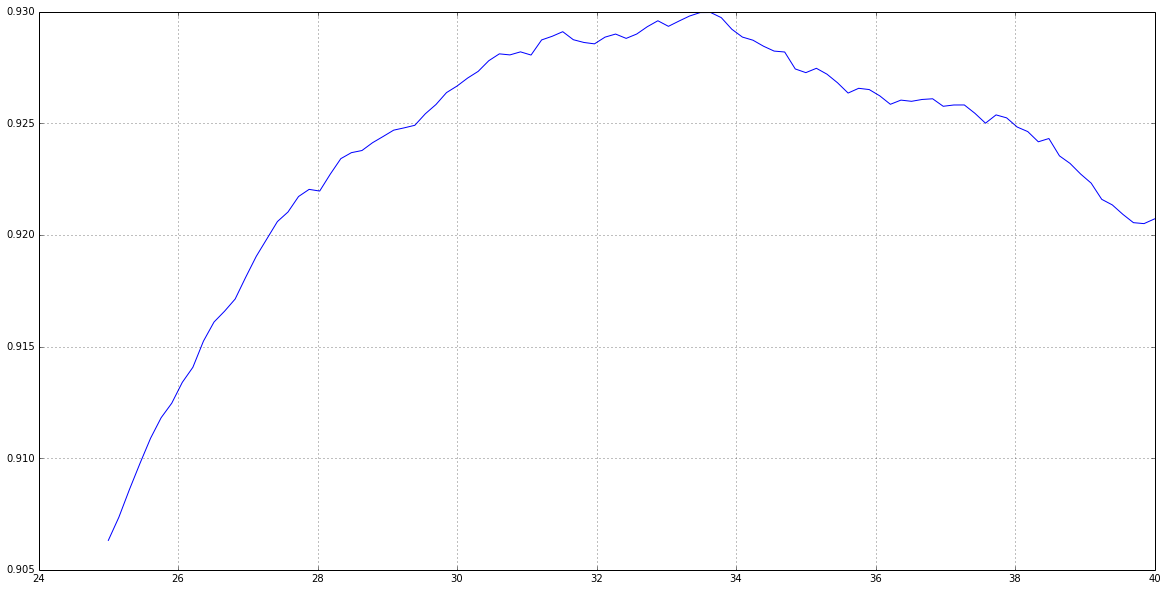

In [25]:
coefs=[]
ccs=[]
for coef in np.linspace(25, 40, num=100):
    noise = 0.065 * np.random.randn(*predicted_data.shape)
    noisy_predicted_data = np.round(predicted_data*coef) + noise
    combined_data = np.vstack([original_data,np.round(predicted_data*coef)])
    gamma = np.corrcoef(combined_data)
    cc = gamma[0,1]
    coefs.append(coef)
    ccs.append(cc)
    print 'coef:%.2f corr_coeff: %.4f' % (coef, cc)

plt.figure(figsize=(20,10)) 
plt.plot(coefs,ccs)
plt.grid()
plt.show()
max_cc, max_coef = max(zip(ccs,coefs))

corr_coeff: 0.930


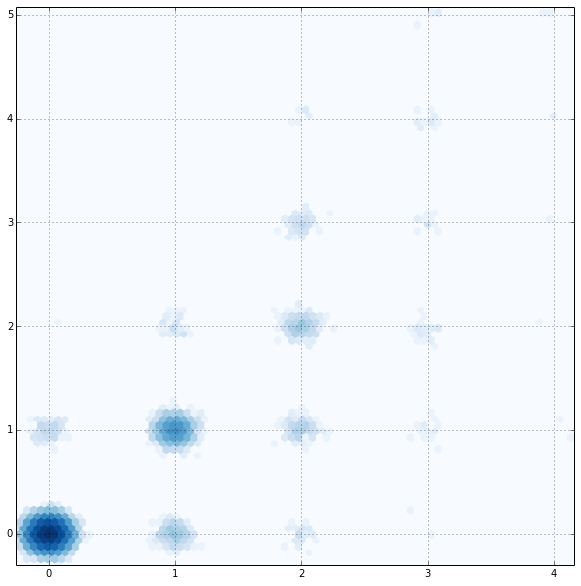

CPU times: user 1.63 s, sys: 12.6 ms, total: 1.64 s
Wall time: 1.64 s


In [26]:
%%time
coef=max_coef
noise = 0.065 * np.random.randn(*predicted_data.shape)
noisy_predicted_data = np.round(predicted_data*coef) + noise
combined_data = np.vstack([original_data,np.round(predicted_data*coef)])
gamma = np.corrcoef(combined_data)
print 'corr_coeff: %.3f' % gamma[0,1]

plt.figure(figsize=(10,10)) 
plt.hexbin(noisy_original_data,noisy_predicted_data,
           bins='log', gridsize=80, cmap='Blues')
plt.grid()
plt.show()

#TODO
- train on two sets the original and the round(50*predicted)
- show that in cv they cannot be distinguished

---